In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats
import seaborn as sns

RANDOM_STATE = 42

In [2]:
# load data
data = pd.read_csv("../data/fraud_data.csv")
data.head()

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1


In [3]:
# check details about the data
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14446 entries, 0 to 14445
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  14446 non-null  object 
 1   merchant               14446 non-null  object 
 2   category               14446 non-null  object 
 3   amt                    14446 non-null  float64
 4   city                   14446 non-null  object 
 5   state                  14446 non-null  object 
 6   lat                    14446 non-null  float64
 7   long                   14446 non-null  float64
 8   city_pop               14446 non-null  int64  
 9   job                    14446 non-null  object 
 10  dob                    14446 non-null  object 
 11  trans_num              14446 non-null  object 
 12  merch_lat              14446 non-null  float64
 13  merch_long             14446 non-null  float64
 14  is_fraud               14446 non-null  object 
dtypes:

In [4]:
# check for null values
data.isnull().sum() 

trans_date_trans_time    0
merchant                 0
category                 0
amt                      0
city                     0
state                    0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [5]:
# discard any samples with incorrectly labeled targets and convert labels to numerical values
changed_data = data.loc[(data["is_fraud"] == "0") | (data["is_fraud"] == "1")].reset_index(drop=True)
changed_data['is_fraud'] = changed_data["is_fraud"].astype("int64")

# turn city and state into a single feature
changed_data["location"] = changed_data.apply(lambda x: x["city"] + ", " + x["state"],axis = 1)
changed_data = changed_data.drop(columns=["city", "state"])

# turn the date of the transaction into a number
changed_data['trans_date_trans_time'] = pd.to_datetime(changed_data['trans_date_trans_time'], format="%d-%m-%Y %H:%M")
changed_data['trans_date_trans_time'] = changed_data['trans_date_trans_time'].map(lambda x: x.timestamp())

# turn the date of birth into a number
changed_data['dob'] = pd.to_datetime(changed_data['dob'], format="%d-%m-%Y")
changed_data['dob'] = changed_data['dob'].apply(lambda x: x.timestamp())

# change transaction number from hex to decimal and then scale it 
# otherwise the model breaks due to its large size
changed_data['trans_num'] = changed_data['trans_num'].apply(lambda x: int(x, 16))
scaler = StandardScaler()
changed_data['trans_num'] = scaler.fit_transform(changed_data[['trans_num']])
print(changed_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14444 entries, 0 to 14443
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  14444 non-null  float64
 1   merchant               14444 non-null  object 
 2   category               14444 non-null  object 
 3   amt                    14444 non-null  float64
 4   lat                    14444 non-null  float64
 5   long                   14444 non-null  float64
 6   city_pop               14444 non-null  int64  
 7   job                    14444 non-null  object 
 8   dob                    14444 non-null  float64
 9   trans_num              14444 non-null  float64
 10  merch_lat              14444 non-null  float64
 11  merch_long             14444 non-null  float64
 12  is_fraud               14444 non-null  int64  
 13  location               14444 non-null  object 
dtypes: float64(8), int64(2), object(4)
memory usage: 1.5+ 

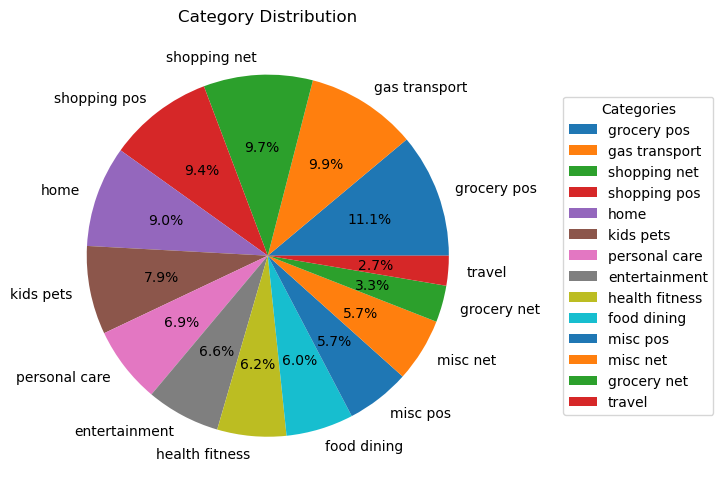

In [6]:
# pie chart of percentages of categories

# Get the frequency of each category
category_counts = changed_data['category'].value_counts()

# get the category names
category_labels = category_counts.index.str.replace("_", " ")

# Plot the pie chart 
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(category_counts, labels=category_labels, autopct='%1.1f%%')
plt.legend(wedges, category_labels, title="Categories", loc="center right", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Category Distribution')
plt.tight_layout()

# save the figure
plt.savefig("../images/category_pie_chart.png", format="png", dpi=300)
plt.show()

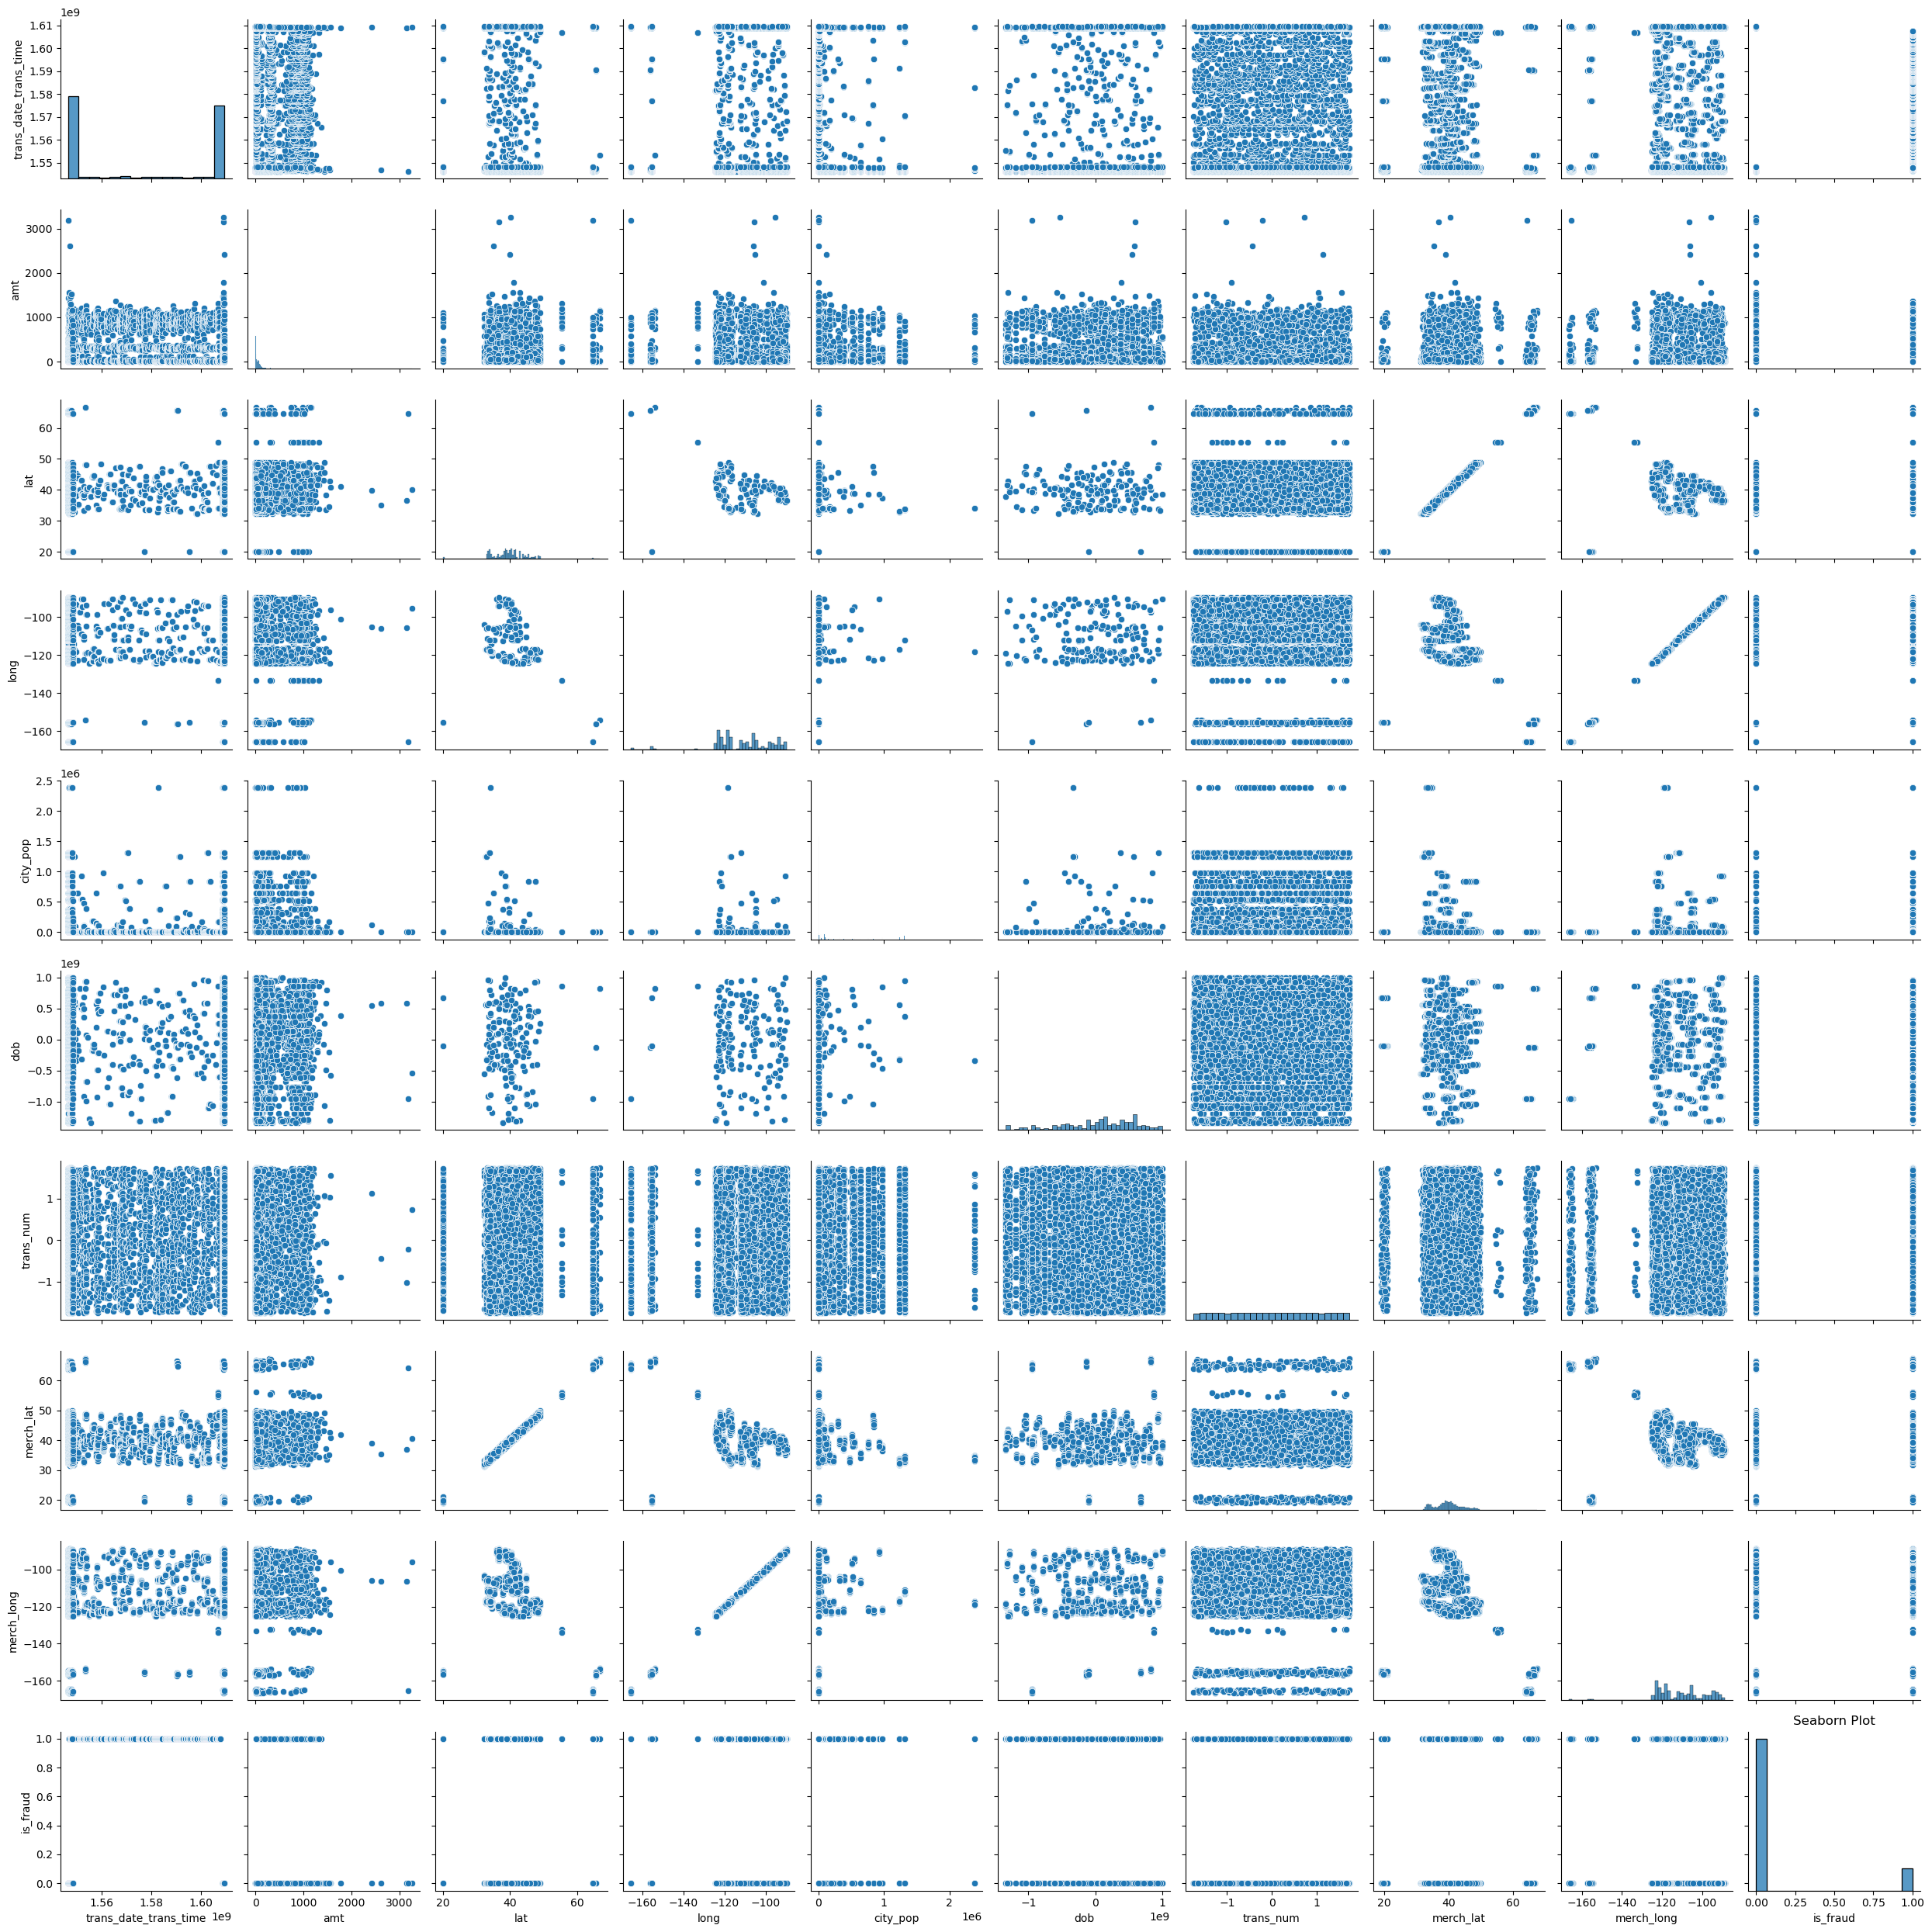

In [7]:
# full graph not very useful
sns.pairplot(changed_data)

plt.title('Seaborn Plot')
plt.tight_layout()
plt.savefig("../images/seaborn_plot.png", format="png", dpi=300)

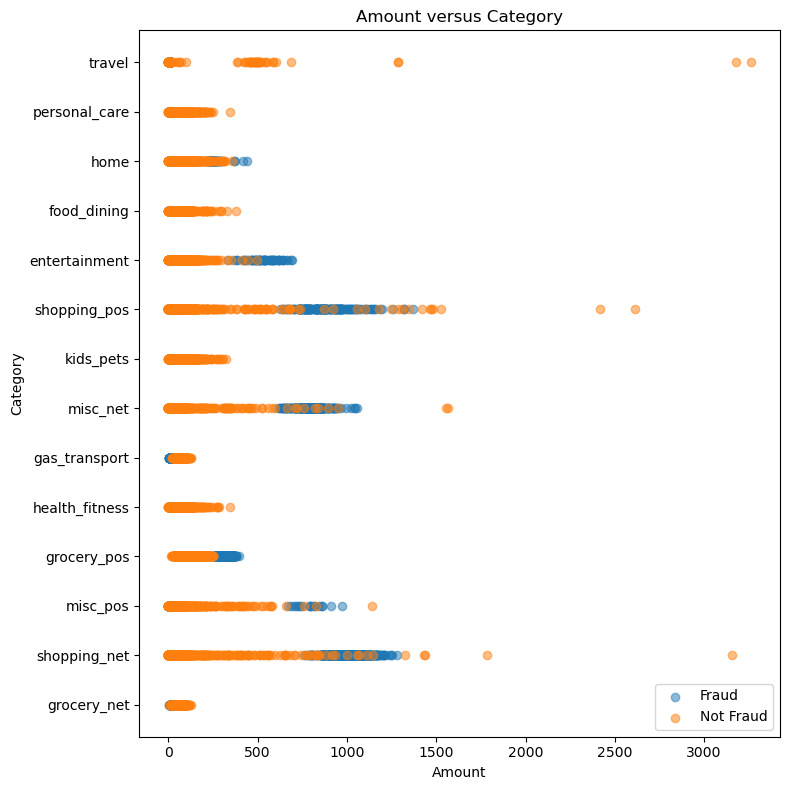

In [8]:
# scatter plot of amount versus category
plt.figure(figsize=(8, 8))

# split the data into fraud and not fraud
fraud_data = changed_data.loc[changed_data["is_fraud"] == 1]
non_fraud_data = changed_data.loc[changed_data["is_fraud"] == 0]

# plot both types of data as amount versus category
plt.scatter(fraud_data["amt"], fraud_data["category"], label="Fraud", alpha=0.5)
plt.scatter(non_fraud_data["amt"], non_fraud_data["category"], label="Not Fraud", alpha=0.5)

plt.title('Amount versus Category')
plt.xlabel("Amount")
plt.ylabel("Category")
plt.legend()
plt.tight_layout()
# save the figure
plt.savefig("../images/amount_versus_category.png", format="png", dpi=300)
plt.show()

In [9]:
# do one hot encoding and remove the last column each time because it is not needed
# since get_dummies create a column for each feature, which creates one more column
# than is needed for one hot encoding
changed_data = pd.get_dummies(changed_data, columns=['category'])
changed_data = changed_data.iloc[:,0:-1]

changed_data = pd.get_dummies(changed_data, columns=['merchant'])
changed_data = changed_data.iloc[:,0:-1]

changed_data = pd.get_dummies(changed_data, columns=['job'])
changed_data = changed_data.iloc[:,0:-1]

changed_data = pd.get_dummies(changed_data, columns=['location'])
changed_data = changed_data.iloc[:,0:-1]

# move the is_fraud column to the end of the dataframe
target_column = changed_data.pop('is_fraud')  
changed_data['is_fraud'] = target_column 

print(changed_data.shape)

(14444, 1053)


In [10]:
# need to scramble because all of the fraudulent transactions are at the start of the dataset
scrambled_data = changed_data.sample(frac=1, random_state=RANDOM_STATE)

# the is_fraud column is last and should not be in X
X = scrambled_data.iloc[:, 0:-1].values
y = scrambled_data['is_fraud']
k_models = []

# the number of samples in each split (size of the test set)
# use 10 since we are doing 10 folds
num_samples_per_split = (int)(len(X) / 10)

for i in range(10):
    # gather the elements before and after the test set for the given k-fold
    X_train_1 = X[0:i*num_samples_per_split,:]
    X_train_2 = X[(i+1)*num_samples_per_split:,:]
    X_train = np.concatenate((X_train_1, X_train_2))
    X_test = X[i*num_samples_per_split:(i+1)*num_samples_per_split,:]

    # do the same for the labels
    y_train_1 = y[0:i*num_samples_per_split]
    y_train_2 = y[(i+1)*num_samples_per_split:]
    y_train = np.concatenate((y_train_1, y_train_2))
    y_test = y[i*num_samples_per_split:(i+1)*num_samples_per_split]

    # train the model and save it along with the data
    model = LogisticRegression().fit(X_train, y_train)
    k_models.append((X_train, X_test, y_train, y_test, model))

In [11]:
# used to save the results of using the k-fold models to predict
accuracies = []
CI_lower_bounds = []
CI_upper_bounds = []
matrices = []

for package in k_models:
    # unpack the data
    (X_train, X_test, y_train, y_test, model) = package
    
    # train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # assess accuracy
    model_accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(model_accuracy)

    # setup to find the confidence intervals
    confidence_level = 0.95
    Z = stats.norm.ppf((1+confidence_level)/2)
    n = len(y_test)
    p = model_accuracy
    
    # Compute confidence interval
    CI = Z * np.sqrt(p*(1-p)/n)
    lower_bound = p - CI
    upper_bound = p + CI    
    CI_lower_bounds.append(lower_bound)
    CI_upper_bounds.append(upper_bound)

    # create confusion matrix for each model
    matrix = confusion_matrix(y_test, y_pred)   
    matrices.append(matrix)

for index, accuracy in enumerate(accuracies):
    print(f"Model {index+1}: {accuracy*100:.4f}%")
print(f"\nMean accuracy {np.mean(accuracies)*100:.4f}%")

Model 1: 91.6205%
Model 2: 92.0360%
Model 3: 92.1745%
Model 4: 92.7978%
Model 5: 92.0360%
Model 6: 92.8670%
Model 7: 90.7895%
Model 8: 92.7285%
Model 9: 92.9363%
Model 10: 93.1440%

Mean accuracy 92.3130%


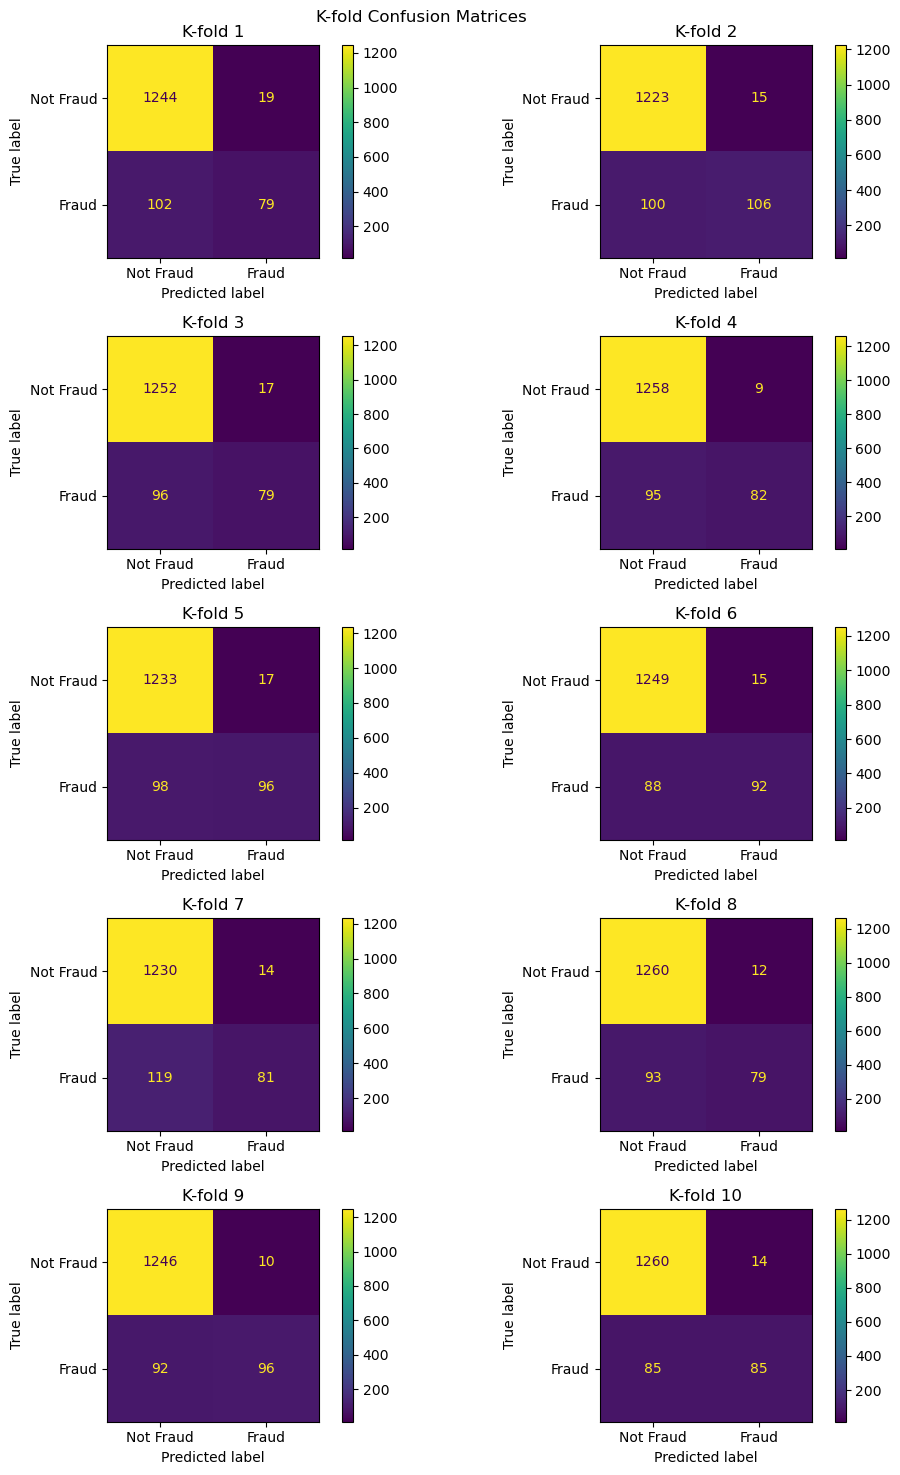

In [12]:
# create space for 10 confusion matrices
fig, axes = plt.subplots(5, 2, figsize=(10,15))

for index, cm, ax in zip(range(len(matrices)), matrices, axes.flatten()):
    ConfusionMatrixDisplay( 
        # use previously stored confusion matrix
        confusion_matrix=cm, 
        display_labels=["Not Fraud", "Fraud"]).plot(ax=ax)
    title = "K-fold "+ str(index +1)
    ax.set_title(title)
fig.suptitle("K-fold Confusion Matrices")
plt.tight_layout()  
plt.savefig("../images/all_confusion_matrices.png", format="png", dpi=300)
plt.show()

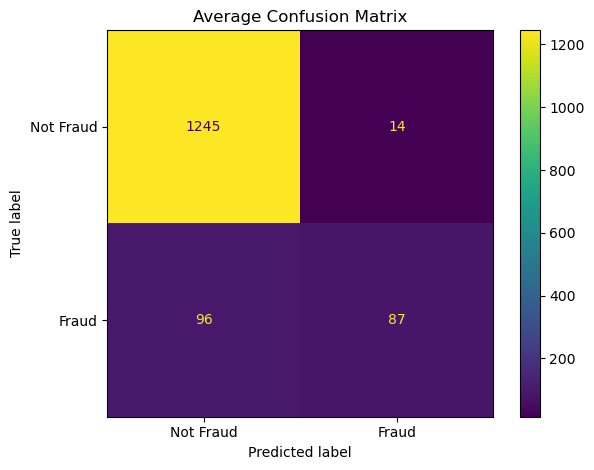

In [13]:
# create an average confusion matrix from the 10 previous ones
matrix_result_average = np.mean(matrices, axis=0)
disp = ConfusionMatrixDisplay(
            # need to convert the averages to an integer for confusion matrix to have the right result
            confusion_matrix=matrix_result_average.astype(int), 
            display_labels=["Not Fraud", "Fraud"])

disp.plot(values_format='d')
plt.title('Average Confusion Matrix')
plt.tight_layout()  
plt.savefig("../images/average_confusion_matrix.png", format="png", dpi=300)
plt.show()

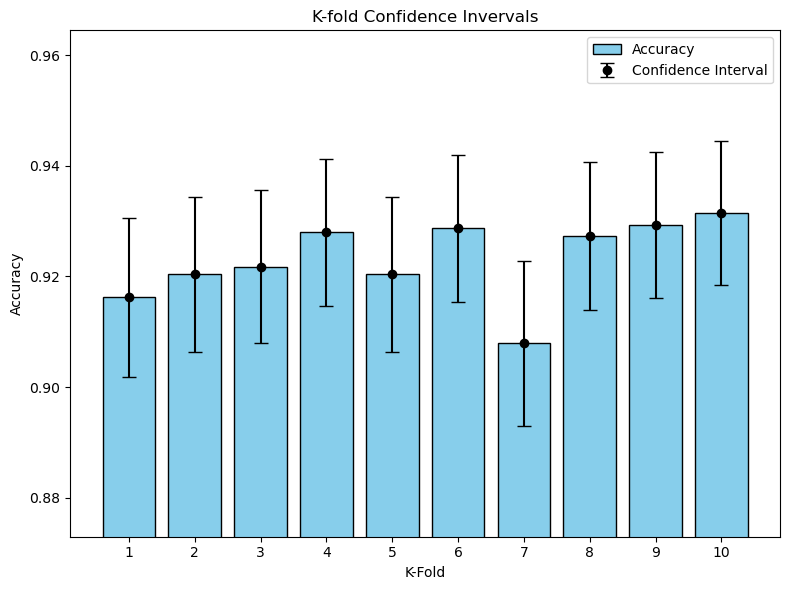

In [14]:
# bar graph for confidence intervals

# create labels
labels = [f"{i + 1}" for i in range(10)]

# Calculate the error margins (distance between accuracy and CI bounds)
lower_errors = [accuracy - lower for accuracy, lower in zip(accuracies, CI_lower_bounds)]
upper_errors = [upper - accuracy for accuracy, upper in zip(accuracies, CI_upper_bounds)]
errors = [lower_errors, upper_errors]

# Create the bar plot with error bars for the confidence interval
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, accuracies, label="Accuracy", color="skyblue", edgecolor="black")
ax.errorbar(labels, accuracies, yerr=errors, fmt='o', color='black', capsize=5, label="Confidence Interval")

# zoom in on the top of the bar graph
ax.set_ylim([min(CI_lower_bounds) - 0.02, max(CI_upper_bounds) + 0.02]) 
ax.set_xlabel("K-Fold")
ax.set_ylabel("Accuracy")
plt.legend()
plt.title("K-fold Confidence Invervals")
plt.tight_layout()
plt.savefig("../images/confidence_intervals.png", format="png", dpi=300)
plt.show()